In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Parameters

In [2]:
hier = False

res = 0.25  # dva

defaults = {'x': 0, 'y': 0, 'r': 2}

In [3]:
# Parameters
hier = False


# Load catalogs

In [4]:
tag = 'hier_' if hier else ''
unit_df = pd.read_csv(f'../../db/{tag}units.csv.gz')
unit_df['Subject'] = [v[:2] for v in unit_df['Session']]

In [5]:
ar_df = pd.read_csv('../../db/bank_array_regions.csv')
ar_df['Subject'] = [v[:2] for v in ar_df['Session']]
ar_df = ar_df.groupby(['Subject', 'Array ID']).first()
unit_df['Region'] = ar_df.loc[pd.MultiIndex.from_frame(unit_df[['Subject', 'Array ID']]), 'Region'].values

In [6]:
slatdf_path = 'summary/rf_fit.csv.gz'
alatdf_path = 'summary/rf_fit-array_level.csv.gz'

assert Path(slatdf_path).is_file()
assert Path(alatdf_path).is_file()

slat_df = pd.read_csv(slatdf_path)
if hier:
    slat_df['Name'] = [f'{v0}/{v1}' for v0, v1 in slat_df[['Level', 'Name']].values]

alat_df = pd.read_csv(alatdf_path)

# Impute values

### Apply resolution for estimates

In [7]:
slat_df[['x', 'y', 'r']] = (slat_df[['x', 'y', 'r']]/res).round().astype(int) * res
alat_df[['x', 'y', 'r']] = (alat_df[['x', 'y', 'r']]/res).round().astype(int) * res

### Per unit, then channel, then array, within session

In [8]:
assert 'Level' in slat_df.columns
unit_df[[['x', 'y', 'r']]] = np.nan
mn = np.isnan(unit_df['x'].values)

for level in ('Unit', 'Channel', 'Array'):
    m = slat_df['Level'] == level
    assert m.any()
    sllat_df = slat_df[m].groupby(['Session', 'Name']).agg({k: np.nanmedian for k in 'xyr'})
    level_col = {'Unit': 'Name', 'Array': 'Array ID'}.get(level, level)
    if hier:
        unit_index = pd.MultiIndex.from_arrays([
            unit_df['Session'],
            [f'{level}/{n}' if level!='Unit' else n for n in unit_df[level_col]]])
    else:
        unit_index = pd.MultiIndex.from_frame(
            unit_df[['Session', level_col]].astype(str))
    unit_index.names = ['Session', 'Name']
    vals = sllat_df[['x', 'y', 'r']].reindex(unit_index).values

    msl_= np.isfinite(vals[:,0])
    msl = mn & msl_
    print(f'{msl_.mean()*100:.1f}% (n = {msl_.sum()}) of units have {level}-level estimates')
    print(f'\t{msl.mean()*100:.1f}% (n = {msl.sum()}) have no previous estimates')
    unit_df.loc[msl, ['x', 'y', 'r']] = vals[msl]
    unit_df.loc[msl, 'Source'] = level

    mn = np.isnan(unit_df['x'].values)
    print(f'{mn.mean()*100:.1f}% (n = {mn.sum()} of units still lack an estimate')
    print()

36.1% (n = 24062) of units have Unit-level estimates
	36.1% (n = 24062) have no previous estimates
63.9% (n = 42683 of units still lack an estimate

24.1% (n = 16106) of units have Channel-level estimates
	8.9% (n = 5911) have no previous estimates
55.1% (n = 36772 of units still lack an estimate

41.8% (n = 27897) of units have Array-level estimates
	21.4% (n = 14303) have no previous estimates
33.7% (n = 22469 of units still lack an estimate



### Per array, across sessions

In [9]:
df_ = alat_df.set_index(['Subject', 'Name'])
assert not df_.index.has_duplicates
vals = df_[['x', 'y', 'r']].reindex(pd.MultiIndex.from_frame(unit_df[['Subject', 'Array ID']])).values
ma = np.isfinite(vals[:,0])
m = ma & np.isnan(unit_df['x'].values)
unit_df.loc[m, ['x', 'y', 'r']] = vals[m]
unit_df.loc[m, 'Source'] = 'Array, across sess'

print(f'{ma.mean()*100:.1f}% (n = {ma.sum()} of units have array-level estimates')
print(f'\t{m.mean()*100:.1f}% (n = {m.sum()}) have no previous estimates')

mn = np.isnan(unit_df['x'].values)
print(f'{mn.mean()*100:.1f}% (n = {mn.sum()} of units still lack an estimate')

56.4% (n = 37632 of units have array-level estimates
	12.7% (n = 8475) have no previous estimates
21.0% (n = 13994 of units still lack an estimate


### Fixed default

In [10]:
mx = np.isnan(unit_df['x'].values)
for k in 'xyr':
    unit_df.loc[mx, k] = defaults[k]
unit_df.loc[mx, 'Source'] = 'Default'
print(f'{mx.mean()*100:.1f}% (n = {mx.sum()} of units used default estimates')

mn = np.isnan(unit_df['x'].values)
print(f'{mn.mean()*100:.1f}% (n = {mn.sum()} of units still lack an estimate')
assert not mn.any()

21.0% (n = 13994 of units used default estimates
0.0% (n = 0 of units still lack an estimate


### Save results

In [11]:
assert np.isfinite(unit_df['x']).all()
assert all(len(v) for v in unit_df['Source'])
df = unit_df[['Session', 'Name', 'x', 'y', 'r', 'Source']]
df.to_csv(f'../../db/per_{tag}unit_rf.csv.gz', index=False)

In [12]:
print('Fraction of estimates from each source:')
(df.groupby(['Source']).count() / len(df) * 100).round(1)

Fraction of estimates from each source:


,Session,Name,x,y,r
Source,,,,,
Array,21.4,21.4,21.4,21.4,21.4
"Array, across sess",12.7,12.7,12.7,12.7,12.7
Channel,8.9,8.9,8.9,8.9,8.9
Default,21.0,21.0,21.0,21.0,21.0
Unit,36.1,36.1,36.1,36.1,36.1


### Summary plots

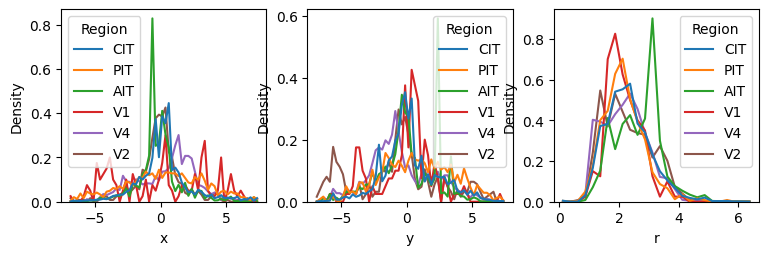

In [13]:
if hier:
    m = unit_df['Source'] != 'Default'
    for level in unit_df['Level'].unique():
        fig, axs = plt.subplots(1, 3, figsize=(9, 2.5))
        for x, ax in zip('xyr', axs):
            sns.histplot(
                data=unit_df[m&(unit_df['Level']==level)],
                x=x, hue='Region', stat='density',
                common_norm=False, binwidth=res, element='poly',
                fill=False, ax=ax)
        axs[0].set_title(level)
else:
    fig, axs = plt.subplots(1, 3, figsize=(9, 2.5))
    for x, ax in zip('xyr', axs):
        sns.histplot(
            data=unit_df[unit_df['Source']!='Default'],
            x=x, hue='Region', stat='density',
            common_norm=False, binwidth=res, element='poly',
            fill=False, ax=ax)